In [1]:
import random 
import os
import sys 

In [2]:
import numpy as np 
import cv2
import json 
from pathlib import Path
import matplotlib.pyplot as plt 

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog,MetadataCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

### Registor dataset

In [5]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
train_json_path = os.path.join(data_dir, 'trainFix.json')
validation_json_path = os.path.join(data_dir, 'validationFix.json')

In [6]:
train_data_name = 'fashion_train'
val_data_name = 'fashion_val'


register_coco_instances(train_data_name, {}, train_json_path, os.path.join(data_dir, 'train') )
register_coco_instances(val_data_name, {}, validation_json_path, os.path.join(data_dir, 'train') )

### Visualize train dataset
* to verify the data loading is correct 

[06/14 22:18:47 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/trainFix.json takes 29.56 seconds.
WARNING [06/14 22:18:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 22:18:48 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/trainFix.json
Path: ../imaterialist-fashion-2020-fgvc7/train/476e4e97ea038261d362f2aac01bd51c.jpg
(753, 500, 3)
Height:  753
Width:  500


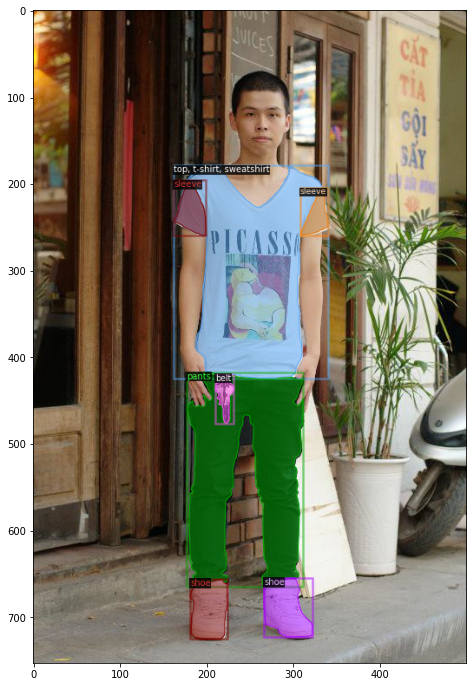

Path: ../imaterialist-fashion-2020-fgvc7/train/f38e4b94504f2a7df3afacfa014cf838.jpg
(1600, 1235, 3)
Height:  1600
Width:  1235


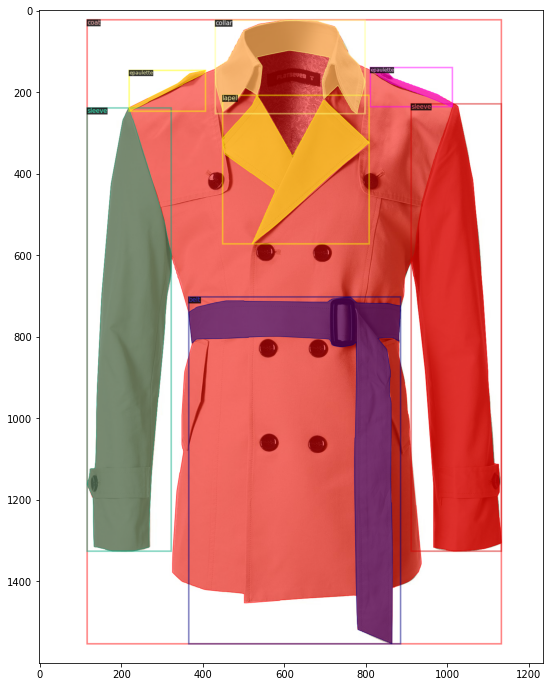

Path: ../imaterialist-fashion-2020-fgvc7/train/f1a8fb8ef4e3639110378d33e39a31bf.jpg
(5602, 4000, 3)
Height:  5602
Width:  4000


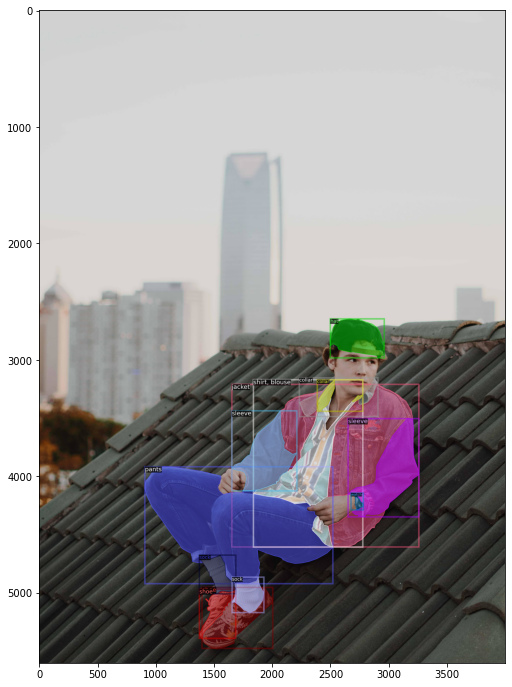

In [7]:
train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    print("Path:",d["file_name"] )
    print(img.shape)
    print("Height: ",d["height"] )
    print("Width: ", d["width"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Set Config and Import model files 

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_data_name,)
cfg.DATASETS.TEST = (val_data_name, )
cfg.TEST.EVAL_PERIOD = 100   # for validation while training 
cfg.DATALOADER.NUM_WORKERS = 10   # CPU cores are 36 => around 36*2 -1 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 50000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # only has one class (ballon)

## Training 

In [9]:
# update create ouptput directory 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [10]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg) 

[06/07 20:10:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/07 20:11:01 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/trainFix.json takes 17.56 seconds.
WARNING [06/07 20:11:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/07 20:11:01 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/trainFix.json
[06/07 20:11:05 d2.data.build]: Removed 0 images with no usable annotations. 41060 images left.
[06/07 20:11:05 d2.data.build]: Distribution of instances among all 46 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| shirt, blouse | 5535         | top, t-shir.. | 14897        |  sweater   | 1341         |
|   cardigan    | 987          |    jacket     | 7027         |    vest    | 652          |
|     pants     | 11152        |    shorts     | 2504         |   sk

In [11]:
# if resume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (47, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (47,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (184, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (184,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (46, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (46,) in the model!


In [12]:
# start training
trainer.train()

[06/07 20:11:11 d2.engine.train_loop]: Starting training from iteration 0
[06/07 20:11:17 d2.utils.events]:  eta: 3:46:23  iter: 19  total_loss: 5.691  loss_cls: 3.855  loss_box_reg: 0.700  loss_mask: 0.691  loss_rpn_cls: 0.261  loss_rpn_loc: 0.053  time: 0.2703  data_time: 0.0715  lr: 0.000005  max_mem: 2674M
[06/07 20:11:23 d2.utils.events]:  eta: 3:48:35  iter: 39  total_loss: 5.546  loss_cls: 3.721  loss_box_reg: 0.620  loss_mask: 0.691  loss_rpn_cls: 0.328  loss_rpn_loc: 0.048  time: 0.2762  data_time: 0.0136  lr: 0.000010  max_mem: 2765M
[06/07 20:11:29 d2.utils.events]:  eta: 3:53:12  iter: 59  total_loss: 5.315  loss_cls: 3.464  loss_box_reg: 0.730  loss_mask: 0.691  loss_rpn_cls: 0.265  loss_rpn_loc: 0.052  time: 0.2793  data_time: 0.0052  lr: 0.000015  max_mem: 2765M
[06/07 20:11:33 d2.engine.hooks]: Overall training speed: 73 iterations in 0:00:20 (0.2824 s / it)
[06/07 20:11:33 d2.engine.hooks]: Total training time: 0:00:20 (0:00:00 on hooks)


KeyboardInterrupt: 

In [13]:
# Look at training cruves in  tensorboard: 
%load_ext tensorboard

In [15]:
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 34848), started 0:02:16 ago. (Use '!kill 34848' to kill it.)

## Inferece with the trained model 

In [ ]:
# inference on our fine-tuned model

# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9


cfg.DATASETS.TEST = (val_data_name,)

backpack_test_metadata = MetadataCatalog.get(val_data_name)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)

In [ ]:
# let's have a look on prediction
test_dataset_dicts = DatasetCatalog.get(val_data_name)

for d in random.sample(test_dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

## Inference on Video

In [ ]:
def inference_on_video(video_path, out_video_path):
    cap = cv2.VideoCapture(video_path)
    cnt = 0

    output_frames = []

    while True:
        ret, im = cap.read()

        if not ret:
            break

        if cnt%5 == 0:
            outputs = predictor(im)
            v = Visualizer(im[:, :, ::-1],
                           metadata=backpack_test_metadata, 
                           scale=0.8, 
#                            instance_mode=ColorMode.IMAGE_BW
                          )
            print(outputs)
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            output_frames.append(v.get_image()[:, :, ::-1])

        cnt = cnt + 1

    height, width, _ = output_frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 10, size)

    for i in range(len(output_frames)):
        out.write(output_frames[i])

    out.release()

In [ ]:
#Output video is stored as out.mp4 with backpack segmentations

inference_on_video(os.path.join(data_dir, 'fashion_walk.mp4'), os.path.join(data_dir, 'fashion_walk_output.mp4'))